In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageStat

import json
import numpy as np
import cv2
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import argparse
import imutils


from os import listdir
from os.path import isfile, join

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import json
import numpy as np
import cv2
from matplotlib import pyplot

#python -m pip install -U scikit-image
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#from skimage.io import imread
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle



In [3]:
dir = "food-101/food-101/images/"

def imOpen(path):
    imPath = dir + path
    img = mpimg.imread(imPath)
    return img

def brightness(im_file):
   im = Image.open(im_file).convert('L')
   stat = ImageStat.Stat(im)
   im.close
   return stat.rms[0]

def image_to_feature_vector(image, size=(256, 256)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [4]:
categories = open('food-101/food-101/meta/classes.txt').read().split()
categories

test = json.load(open('food-101/food-101/meta/test.json'))
train = json.load(open('food-101/food-101/meta/train.json'))

# count_test = np.array(list(test.values()))
# print('Number of Test Images:', count_test.shape[0] * count_test.shape[1])

# count_train = np.array(list(train.values()))
# print('Number of Train Images:', count_train.shape[0] * count_train.shape[1])

# whole = {}
# for key in test.keys():
#     whole[key] = test[key]
#     whole[key] += train[key]

# count_whole = np.array(list(whole.values()))
# print('Total Number of Images:', count_whole.shape[0] * count_whole.shape[1])

# print('Number of categories:', len(categories))
# print('Number of photos per category:', len(whole['apple_pie']))
# print('List of categories:', categories)

# plt.imshow(imOpen(train[categories[0]][0] + '.jpg'));

# print('\nTrain Dataset')
# print('Example Keys:', list(train.keys())[:5])
# print('Example Values:', train['churros'][:5])
# print('\nTest Dataset')
# print('Example Keys:', list(test.keys())[:5])
# print('Example Values:', test['churros'][:5])

In [8]:
#DATASET IS TOO LARGE AHHH
#TIME TO RANDOM SAMPLE
#Select number of images to be random sampled
randomSampleCount = 500 # 50

# random.seed(255)
sequence = [i for i in range(1001)]
randList = random.sample(sequence, randomSampleCount)

randomSampled = []
scaleddir = 'food-101/food-101/imagesScaled/'
for cat in categories:
    directory = scaleddir + cat
    path = os.listdir(directory)
    index = 0
    imagesToBeSampled = []
    for images in path:
        index = index + 1
        if(index in randList):
            imagesToBeSampled.append(images)
    randomSampled.append(imagesToBeSampled)
print(randomSampled[0][:25])

# 50 random images from each of the 101 categories

['2853890.jpg', '1579622.jpg', '3134347.jpg', '3314985.jpg', '2047916.jpg', '1420227.jpg', '1847621.jpg', '3670548.jpg', '2766017.jpg', '1088809.jpg', '1174330.jpg', '1284682.jpg', '739615.jpg', '112378.jpg', '2596943.jpg', '3065929.jpg', '1112300.jpg', '3116086.jpg', '2582077.jpg', '939768.jpg', '2767057.jpg', '3603821.jpg', '1617793.jpg', '885848.jpg', '2132230.jpg']


In [9]:
%%time

#SVM WORK
from sklearn.preprocessing import MinMaxScaler
flat = []
images2 = []
#Resized array ***CRITICAL USE RESIZED ARRAY
scaleddir = 'food-101/food-101/imagesScaled/'

#This gets all images and puts them into a dataframe
#DESIGN NOTES
#Changes image size to 50x50 due to processign speed. 250x250 increases processing time by 30% which scales exponentially.
index = 0
for cat in random.sample(categories, 5): #categories[:50]:
    print(f'processing category {index}: {cat}...')
    directory = scaleddir + cat    
    # path = randomSampled[index]
    path = [f for f in listdir(directory) if isfile(join(directory, f))]
    index = index + 1
    for images in path:
        toArr = imread(os.path.join(directory, images))
        img_resized = resize(toArr, (50, 50, 3))
        flat.append(img_resized.flatten())
        images2.append(cat)

print('converting image data into dataframe...')
df = pd.DataFrame(np.array(flat))
print('appending category name to dataframe...')
df['Target'] = np.array(images2)

#Here we create our test to data split, Default is 30
ts = .30
rs = 45
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
print('Splitting into train and test sets...')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ts, random_state=rs, stratify=y)

print()
print("Number of training data: " + str(len(x_train)))
print("Number of testing data: " + str(len(x_test)))
print()



processing category 0: chicken_curry...
processing category 1: french_toast...
processing category 2: eggs_benedict...
processing category 3: macarons...
processing category 4: chocolate_mousse...
converting image data into dataframe...
appending category name to dataframe...
Splitting into train and test sets...

Number of training data: 3500
Number of testing data: 1500

CPU times: user 19.4 s, sys: 480 ms, total: 19.9 s
Wall time: 20.2 s


In [10]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1,21, 2))
param_grid = dict(n_neighbors = k_range)

grid = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=3)
grid_search = grid.fit(x_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

knn2 = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn2.fit(x, y)
y_test_hat=knn2.predict(x_test) 
test_accuracy=np.mean(y_test_hat == y_test)*100 # accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ..................................n_neighbors=1; total time=   0.5s
[CV 2/2] END ..................................n_neighbors=1; total time=   0.4s
[CV 1/2] END ..................................n_neighbors=3; total time=   0.4s
[CV 2/2] END ..................................n_neighbors=3; total time=   0.4s
[CV 1/2] END ..................................n_neighbors=5; total time=   0.4s
[CV 2/2] END ..................................n_neighbors=5; total time=   0.4s
[CV 1/2] END ..................................n_neighbors=7; total time=   0.4s
[CV 2/2] END ..................................n_neighbors=7; total time=   0.4s
[CV 1/2] END ..................................n_neighbors=9; total time=   0.4s
[CV 2/2] END ..................................n_neighbors=9; total time=   0.4s
[CV 1/2] END .................................n_neighbors=11; total time=   0.4s
[CV 2/2] END .................................n_

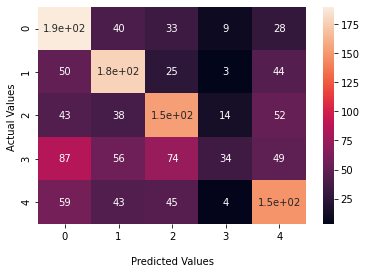

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, y_test_hat)

ax = sns.heatmap(cf_matrix, annot=True)

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [38]:
def createRandomData():
    flat = []
    images2 = []
    scaleddir = 'food-101/food-101/imagesScaled/'

    index = 0
    for cat in random.sample(categories, 5): 
        directory = scaleddir + cat    
        path = [f for f in listdir(directory) if isfile(join(directory, f))]
        index = index + 1
        for images in path:
            toArr = imread(os.path.join(directory, images))
            img_resized = resize(toArr, (50, 50, 3)) 
            flat.append(img_resized.flatten())
            images2.append(cat)

    df = pd.DataFrame(np.array(flat))
    df['Target'] = np.array(images2)

    ts = .30
    rs = 45
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ts, random_state=rs, stratify=y)

    return x_train, x_test, y_train, y_test, x, y

In [49]:
def runKNN(x_train, x_test, y_train, y_test, x, y):
    
    knn = KNeighborsClassifier()
    k_range = list(range(1,21, 2))
    param_grid = dict(n_neighbors = k_range)

    grid = GridSearchCV(knn, param_grid, cv=2, scoring='accuracy')
    grid_search = grid.fit(x_train, y_train)

    best_param = grid_search.best_params_

    knn2 = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
    knn2.fit(x, y)
    y_test_hat=knn2.predict(x_test) 
    test_accuracy=np.mean(y_test_hat == y_test)*100 
    
    return best_param, test_accuracy, knn2

In [50]:
%%time
x_train, x_test, y_train, y_test, x, y = createRandomData()
best_param, test_accuracy, knn = runKNN(x_train, x_test, y_train, y_test, x, y)
print(best_param, test_accuracy)

{'n_neighbors': 15} 42.0
CPU times: user 1min 25s, sys: 4.98 s, total: 1min 30s
Wall time: 30.1 s


In [60]:
accuracies = []
params = []

for i in range(100):
    print(f'Processing Epoch {i}...')
    x_train, x_test, y_train, y_test, x, y = createRandomData()
    best_param, test_accuracy, knn = runKNN(x_train, x_test, y_train, y_test, x, y)
    accuracies.append(test_accuracy)
    params.append(best_param['n_neighbors'])
    print(f'Epoch {i}: {test_accuracy}% Accuracy\n')

Processing Epoch 0...
Epoch 0: 34.53333333333333% Accuracy

Processing Epoch 1...
Epoch 1: 39.06666666666666% Accuracy

Processing Epoch 2...
Epoch 2: 41.86666666666667% Accuracy

Processing Epoch 3...
Epoch 3: 38.266666666666666% Accuracy

Processing Epoch 4...
Epoch 4: 41.46666666666667% Accuracy

Processing Epoch 5...
Epoch 5: 38.4% Accuracy

Processing Epoch 6...
Epoch 6: 100.0% Accuracy

Processing Epoch 7...
Epoch 7: 42.733333333333334% Accuracy

Processing Epoch 8...
Epoch 8: 44.13333333333333% Accuracy

Processing Epoch 9...
Epoch 9: 53.13333333333333% Accuracy

Processing Epoch 10...
Epoch 10: 39.666666666666664% Accuracy

Processing Epoch 11...
Epoch 11: 38.0% Accuracy

Processing Epoch 12...
Epoch 12: 39.46666666666667% Accuracy

Processing Epoch 13...
Epoch 13: 100.0% Accuracy

Processing Epoch 14...
Epoch 14: 36.8% Accuracy

Processing Epoch 15...
Epoch 15: 37.8% Accuracy

Processing Epoch 16...
Epoch 16: 41.06666666666667% Accuracy

Processing Epoch 17...
Epoch 17: 44.266

In [86]:
print('accuracies:', accuracies, '\n')
print('parameters:', params)

accuracies: [34.53333333333333, 39.06666666666666, 41.86666666666667, 38.266666666666666, 41.46666666666667, 38.4, 100.0, 42.733333333333334, 44.13333333333333, 53.13333333333333, 39.666666666666664, 38.0, 39.46666666666667, 100.0, 36.8, 37.8, 41.06666666666667, 44.266666666666666, 59.0, 39.800000000000004, 48.46666666666667, 40.666666666666664, 100.0, 52.93333333333333, 53.733333333333334, 36.266666666666666, 39.93333333333333, 44.93333333333333, 36.8, 46.733333333333334, 38.666666666666664, 39.93333333333333, 42.199999999999996, 36.199999999999996, 36.93333333333334, 100.0, 49.333333333333336, 42.333333333333336, 49.8, 45.4, 40.400000000000006, 100.0, 46.400000000000006, 31.333333333333336, 35.733333333333334, 43.46666666666666, 54.46666666666666, 52.733333333333334, 44.800000000000004, 51.800000000000004, 44.333333333333336, 42.199999999999996, 38.733333333333334, 41.66666666666667, 40.266666666666666, 41.53333333333333, 39.53333333333333, 45.46666666666667, 100.0, 31.4, 42.53333333

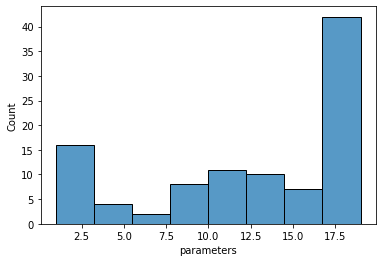

In [87]:
data = pd.DataFrame({'accuracy':accuracies, 'parameters':params})
sns.histplot(data=data, x='parameters');

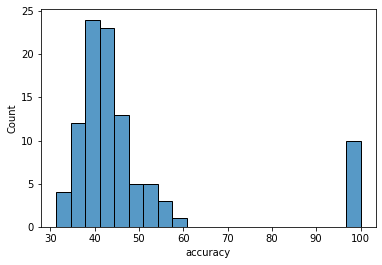

In [79]:
sns.histplot(data=data, x='accuracy');

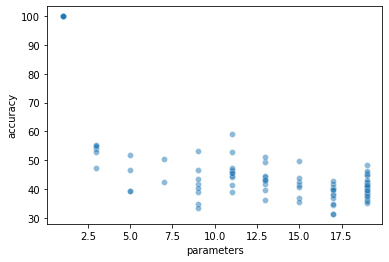

In [83]:
sns.scatterplot(data=data, x='parameters', y='accuracy', alpha=0.5);

In [90]:
data.mean()

accuracy      48.306
parameters    12.620
dtype: float64

In [91]:
data.median()

accuracy      42.266667
parameters    13.000000
dtype: float64

From 100 iterations of random testing, we can see that the average accuracy is ~48.31% with an average k value of 12-13. Interestingly enough, some of these random iterations concluded that the best fit model was a k of 1, resulting in a 100% accuracy.

In [37]:
# from sklearn.metrics import multilabel_confusion_matrix
# multilabel_confusion_matrix(y_test, y_test_hat, labels=np.unique(y_test_hat))